# **230M HW1 by Group 1**

**How to run this - Run the notebook cell by cell**

# **Q1**

In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from scipy.stats import norm
from scipy.optimize import least_squares, fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import locale

In [38]:
# load data
df = pd.read_csv('data_hw1/sofr_cap_accruals_20230413.csv', parse_dates = ['Pay Date', 'Accrual Start', 'Accrual End'])

p_acc = pd.read_csv('data_hw1/P_caplet_accruals_20230413.csv', header = None)
p_pmt = pd.read_csv('data_hw1/P_caplet_payments_20230413.csv', header = None)

caps = pd.read_csv('data_hw1/cap_sofr_atm_strikes_20230413.csv', header = None).rename(columns = {0:"Strikes"})
vols = pd.read_csv('data_hw1/cap_sofr_atm_bachelier_vols_20230413.csv', header = None)

# **Q1 a)**

In [39]:
settlement_date           = pd.to_datetime('04/17/2023')
df['Accrual Time Period'] = (df['Accrual End'] - df['Accrual Start']).dt.days/360

# **Q1 b)**

In [40]:
df['Forward SOFR']        = (p_acc.shift(1)/p_acc - 1).dropna().reset_index(drop=True)
df['Forward SOFR']        = df['Forward SOFR'] / df['Accrual Time Period']

# **Q1 c)**

In [41]:
df['Maturity Time']       = (df['Accrual End'] - settlement_date).dt.days/365
df['Maturity Time -1']    = (df['Accrual Start'] - settlement_date).dt.days/365
df['Proxy Time']          = df['Maturity Time'].shift(1) + (df['Maturity Time'] - df['Maturity Time'].shift(1))/3
df.loc[0, 'Proxy Time']   = df.loc[0, 'Maturity Time']/3

In [42]:
df

,Pay Date,Days,Accrual Start,Accrual End,Accrual Time Period,Forward SOFR,Maturity Time,Maturity Time -1,Proxy Time
0,2023-07-19,91,2023-04-17,2023-07-17,0.252778,0.049815,0.249315,0.000000,0.083105
1,2023-10-19,92,2023-07-17,2023-10-17,0.255556,0.048557,0.501370,0.249315,0.333333
2,2024-01-19,92,2023-10-17,2024-01-17,0.255556,0.045185,0.753425,0.501370,0.585388
3,2024-04-19,91,2024-01-17,2024-04-17,0.252778,0.041206,1.002740,0.753425,0.836530
4,2024-07-19,91,2024-04-17,2024-07-17,0.252778,0.034588,1.252055,1.002740,1.085845
...,...,...,...,...,...,...,...,...,...
115,2052-04-19,91,2052-01-17,2052-04-17,0.252778,0.022698,29.021918,28.772603,28.855708
116,2052-07-19,91,2052-04-17,2052-07-17,0.252778,0.022698,29.271233,29.021918,29.105023
117,2052-10-21,92,2052-07-17,2052-10-17,0.255556,0.022699,29.523288,29.271233,29.355251
118,2053-01-22,92,2052-10-17,2053-01-17,0.255556,0.022699,29.775342,29.523288,29.607306


# **Q1 d)**

In [43]:
def caplet_bachelier(F,K,sig,T):
    '''
    Function that calculates price of ATM cap using Bachelier formula
    F: Forward Rate
    K: Strike
    sig: sigma
    T: Time to expiry
    '''
    d = (F - K)/(sig*np.sqrt(T))
    return sig*np.sqrt(T)*norm.pdf(d) + (F-K)*norm.cdf(d)

In [44]:
# Store values needed for cap pricing
caps['Vols']              = vols
caps['Expiry']            = [1,2,3,4,5,6,7,8,9,10,12,15,20,25,30]
caps['No_Caplets']        = 4*caps['Expiry'] # 1 cap = 4 quarters
pv_bach                   = []
N                         = 10_000_000
df['PV (PMT)']            = p_pmt
df['PV (PMT) -1']         = p_pmt.shift(1)
df.loc[0, 'PV (PMT) -1']  = 1

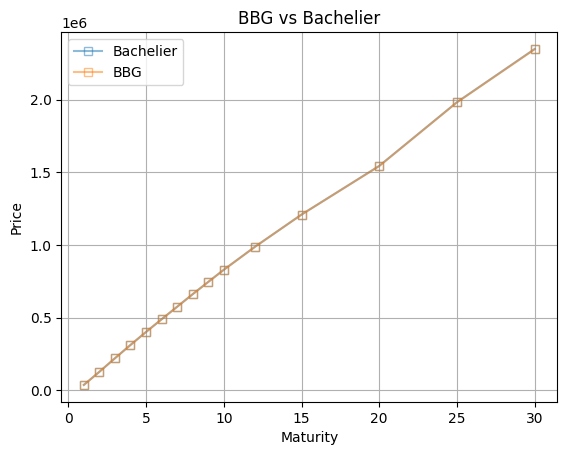

In [45]:
# Iterate over all caps
for index, row in caps.iterrows():
    pv = 0
    # Iterate over all caplets within the cap
    for index2, row2 in df[:int(row.No_Caplets)].iterrows():
        pv += N*row2['PV (PMT)'] * caplet_bachelier(row2['Forward SOFR'], row['Strikes'], row['Vols']/10000, row2['Proxy Time']) * row2['Accrual Time Period']
    pv_bach.append(pv)
pv_bach = np.array(pv_bach)

# Comparing with BBG values
bbg_pvs = pd.read_csv('data_hw1/sofr_cap_bloomberg_pv_20230413.csv', header = None)
plt.plot(caps['Expiry'], pv_bach, marker='s', alpha=0.5, markerfacecolor='none', label = 'Bachelier')
plt.plot(caps['Expiry'], bbg_pvs, marker='s', alpha=0.5, markerfacecolor='none', label = 'BBG')
plt.legend()
plt.xlabel("Maturity")
plt.ylabel("Price")
plt.title("BBG vs Bachelier")
plt.grid(True)
plt.show()

# **Q1 e)**

In [46]:
def caplet_hullwhite(k, sig, X, tau, pti, ptim, ti, tim, t0):
    """
    Calculate price of caplet in Hull White model
    """
    sig_pt = np.sqrt(var_p(k,sig,t0,ti,tim))
    hit = hi(k, sig, X, tau, pti, ptim, ti, tim, t0)
    t1 = ptim*norm.cdf(-hit + sig_pt)
    t2 = (1 + X*tau)*pti*norm.cdf(-hit)
    return t1 - t2

def var_p(k,sig,t0,ti,tim):
    """
    Calculate var_p
    """
    t1 = sig*sig/(2*k)*((1 - np.exp(-k*(ti-tim)))/k)**2
    t1 *= (1 - np.exp(-2*k*(tim-t0)))
    t2 = sig*sig/(k*k)*(ti - tim + (2/k)*np.exp(-k*(ti-tim)) - (1/(2*k))*np.exp(-2*k*(ti-tim)) - 3/(2*k))
    return t1 + t2

def hi(k, sig, X, tau, pti, ptim, ti, tim, t0):
    """
    Calculate h_i
    """
    sig_pt = np.sqrt(var_p(k,sig,t0,ti,tim))
    return 1/(sig_pt)*np.log(pti*(1 + X*tau)/(ptim)) + sig_pt/2

In [47]:
def find_parameters(params):
    """
    Diff between Hull White model and Bachelier model.
    """
    k, sig = params
    pv_hw = []
    N = 10_000_000
    for index, row in caps.iterrows():
        pv = 0
        for index2, row2 in df[:int(row.No_Caplets)].iterrows():
            pv += N*caplet_hullwhite(k, sig, row['Strikes'], row2['Accrual Time Period'], row2['PV (PMT)'], row2['PV (PMT) -1'], row2['Maturity Time'], row2['Maturity Time -1'] , 0)
        pv_hw.append(pv)
    pv_hw = np.array(pv_hw)
    return (pv_bach - pv_hw)

initial_params = [0.01, 0.01] #initial guess
result = least_squares(find_parameters, initial_params)
k, sig = result.x
print(f"Kappa = {k:.10f}, \nSigma = {sig:.10f}")

Kappa = 0.0770909270, 
Sigma = 0.0135251765


# **Q1 f)**

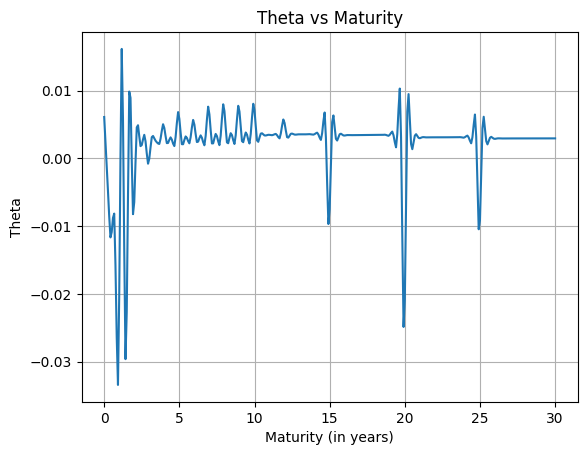

Mean: 0.0022553567856032396
Median: 0.003106087353255414
Minimum: -0.03341171741231335
Maximum: 0.016136048554604966


In [48]:
## Calculate theta

# Calculate interpolated PV
y = pd.concat([pd.Series(1), p_pmt[0]], ignore_index=True)
x = pd.concat([pd.Series(0), (df['Pay Date'] - settlement_date).dt.days/365], ignore_index=True)
f = interp1d(x,y,kind='cubic')

# Calculate f from interpolated PV
xnew = np.arange(0,30  + 1/12,1/12)
ynew = f(xnew)
fm = -(np.log(ynew[1:]) - np.log(ynew[:-1]))/(1/12)
fm = interp1d(xnew[:-1], fm,kind='cubic', bounds_error = False, fill_value = "extrapolate")
ynew = fm(xnew)

# Calculate df from interpolated f
dfm = (ynew[1:] - ynew[:-1])/(1/12)
dfm = interp1d(xnew[:-1], dfm,kind='cubic', bounds_error = False, fill_value = "extrapolate")
ynew = dfm(xnew)

# Calculate theta from df, f.
tht = dfm(xnew) + k*fm(xnew) + sig**2/(2*k)*(1 - np.exp(-2*k*xnew))
tht = interp1d(xnew, tht,kind='cubic', bounds_error = False, fill_value = "extrapolate")
ynew = tht(xnew)


# Plot theta
plt.plot(xnew, ynew)
plt.xlabel("Maturity (in years)")
plt.ylabel("Theta")
plt.title("Theta vs Maturity")
plt.grid(True)
plt.show()

# Print the summary
mean_value = np.mean(ynew)
median_value = np.median(ynew)
min_value = np.min(ynew)
max_value = np.max(ynew)

# Print the summary

print(f"Mean: {np.mean(ynew)}")
print(f"Median: {np.median(ynew)}")
print(f"Minimum: {np.min(ynew)}")
print(f"Maximum: {np.max(ynew)}")


# **Q2**

# **Q2 a)**

In [49]:
# Define parameters

# Correlation between r_t and A_t
rho = np.sqrt(3)/2

# step size is monthly
dt = 1/12

# Initial SOFR rate (calculated from prospectus)
ini_sofr = (0.056617 - 0.0092)



In [50]:
def simulate_rt_at(n, rho = rho, dt = dt, ini_sofr = ini_sofr, anti = False):
    """
    Simulate the interest rate path assuming Hull White model.
    Next period depends on the current period.
    anti: if True, will append antithetic paths to end of sim.
    """
    sim = np.zeros((2, n, 30*12 + 1))
    sim[:,:,0] = ini_sofr
    if anti:
        asim = np.zeros((2, n, 30*12 + 1))
        asim[:,:,0] = ini_sofr
    size = (2, n, 30*12)
    eps = np.random.randn(*size)
    for t in range(30*12):
        epsr = eps[0,:,t]
        epsA = epsr*rho + eps[1,:n,t]*np.sqrt(1 - rho**2)
        sim[0,:,t+1] = sim[0,:,t] + (tht(t*dt) - k*sim[0,:,t])*dt + epsr*sig*np.sqrt(dt)
        sim[1,:,t+1] = sim[0,:,t] + 0.5*(tht(t*dt) - k*sim[0,:,t])*dt + epsA*sig*np.sqrt(dt/3)
        if anti:
            asim[0,:,t+1] = asim[0,:,t] + (tht(t*dt) - k*asim[0,:,t])*dt - epsr*sig*np.sqrt(dt)
            asim[1,:,t+1] = asim[0,:,t] + 0.5*(tht(t*dt) - k*asim[0,:,t])*dt - epsA*sig*np.sqrt(dt/3)
    if anti:
        sim = np.concatenate((sim, asim), axis = 1)
    return sim[0,:,:], sim[1,:,:]

In [51]:
def _B(t,T):
    """
    Calculate B(t,T) of Hull White
    """
    return (1 - np.exp(-k*(T-t)))/k

def _A(t,T):
    """
    Calculate A(t,T) of Hull White
    """
    val = 0
    for i in range(int((T-t)/dt)):
        val += -_B(t+i*dt, T)*tht(t+i)*dt
    adj = sig**2/(2*k**2)*((T-t)+(1-np.exp(-2*k*(T-t)))/(2*k)-2*_B(t,T))
    return val + adj

def _y(t,T,r):
    """
    Calculate yield acc to Hull White
    """
    return (_B(t,T)*r-_A(t,T))/(T-t)

def _y_pc(t,T,r,A,B):
    """
    Same as _y, except use precomputed values of A and B
    """
    return (B*r - A)/(T-t)

def ten_year_rate(rt, dt = dt):
    """
    Calculate 10 year rates from Hull White model
    """
    sim_10_year = np.zeros(rt.shape)
    t_lst = np.arange(0,dt*360+dt,dt)
    for i,t in enumerate(t_lst):
        A = _A(t,t+10)
        B = _B(t,t+10)
        sim_10_year[:, i] = _y_pc(t, t+10, rt[:, i], A, B)
    return sim_10_year

In [52]:
def calc_Zs(at, dt = dt):
    """
    Calculate discount factors
    """
    Zs = np.zeros(at.shape)
    for i in range(360+1):
        Zs[:, i] = np.exp(-dt * np.sum(at[:, 1:(i+1)], axis = 1))
    return Zs

In [53]:
WAC = 7.47/100
WAM = 354
beta = 0.38089

def _PSA(t,WAM = WAM):
    """
    Return PSA at time t
    """
    return 0.06*np.minimum(1,(t+360-WAM)/30)



In [54]:
def _SMM(CPR):
    """
    Convert a CPR to SMM
    """
    return (1-np.power(1-CPR, 1/12))

In [55]:
def prepayment_ts(sim_10_year, WAC = WAC, WAM = WAM, beta = beta):
    """
    Calculate the prepayment vector at 250PSA
    """
    prepay_ts = np.zeros(sim_10_year.shape)
    for i in range(WAM+1):
        CPR = 2.5*_PSA(i)
        curr_SMM = _SMM(CPR)
        prepay_ts[:, i] = curr_SMM*np.exp(beta*(WAC - sim_10_year[:, i]))
    return prepay_ts

In [56]:
ost_init = 94_894_021
WAC      = 7.47/100
WAM      = 354
S_fee    = 0.97/100



In [57]:
def pool_cf(prepay_ts, ost_init = ost_init, WAC = WAC, S_fee = S_fee, WAM = WAM):
    '''
    Calculate Collateral cashflows given a prepayment function
    '''
    c  = WAC / 12
    M  = ost_init

    prn_ss     = np.zeros(prepay_ts.shape)
    prn_uss    = np.zeros(prepay_ts.shape)
    Ps         = np.zeros(prepay_ts.shape)
    Is         = np.zeros(prepay_ts.shape)
    Ms         = np.zeros(prepay_ts.shape)
    servicing  = np.zeros(prepay_ts.shape)
    cfs        = np.zeros(prepay_ts.shape)
    Ms[:,0]    = M

    for i in range(1,WAM+1):
        n              = WAM - (i-1)
        pmt            = Ms[:,i-1]*(c*(1+c)**n)/((1+c)**n-1)
        Is[:,i]        = c*Ms[:,i-1]
        prn_ss[:,i]    = pmt - Is[:,i]
        prn_uss[:,i]   = np.maximum((Ms[:,i-1] - prn_ss[:,i]) * prepay_ts[:,i],0)
        Ps[:,i]        = prn_ss[:,i] + prn_uss[:,i]
        servicing[:,i] = S_fee * Ms[:,i-1] /12
        cfs[:,i]       = Ps[:,i] +  Is[:,i] + servicing[:,i]
        Ms[:,i]        = Ms[:,i-1] - Ps[:,i]
    return Ms, Is, Ps

In [58]:
def _g(x, ceil = 5.58/100):
    '''
    Adds a cap at ceil and a floor at 0%
    '''
    return np.maximum(np.minimum(x,ceil/12),0)



In [59]:
def _FA_coupon(bal, at_t, spread = 0.92/100):
    '''
    Coupon for floater
    '''
    return bal*(_g(at_t*dt) + spread/12)



In [60]:
def _SA_coupon(bal, at_t, inverse_spread = 5.58/100):
    '''
    Coupon for inverse floater
    '''
    return bal*(inverse_spread/12 - _g(at_t*dt))

In [61]:
def bond_cfs(Ms, Ps, at, WAM = WAM):
    '''
    Calculate bond cashflows for both the floater and inverse floater
    '''
    FA_cfs = np.zeros(Ms.shape)
    SA_cfs = np.zeros(Ms.shape)
    for t in range(1, WAM+1):
        FA_cfs[:, t] = _FA_coupon(Ms[:, t-1], at[:, t])
        SA_cfs[:, t] = _SA_coupon(Ms[:, t-1], at[:, t])
        FA_cfs[:, t] += Ps[:, t]
    return FA_cfs, SA_cfs

In [62]:
def price_bond(n = 1, anti = False):
    '''
    Combine everything and price bonds.
    n: Number of Monte Carlo simulations
    anti: if True, use Antithethic paths
    '''
    rt, at     = simulate_rt_at(n, anti = anti)
    plt.plot(at[0,:]/12)
    plt.show()
    plt.plot(_g(at[0,:]/12))
    plt.show()
    ten_yr_rt  = ten_year_rate(rt)
    Zs         = calc_Zs(at + 0.0090)
    prepay_ts  = prepayment_ts(ten_yr_rt)
    print(prepay_ts[0,:])
    Ms, Is, Ps = pool_cf(prepay_ts)
    facf, sacf = bond_cfs(Ms, Ps, at)

    fa         = np.sum((facf * Zs), axis = 1)
    sa         = np.sum((sacf * Zs), axis = 1)
    if anti:
        fa     = (fa[:n] + fa[n:])/2
        sa     = (sa[:n] + sa[n:])/2
    return fa, sa

In [63]:
def print_stats(fa, sa):
    '''
    Function to print out statistics
    '''

    locale.setlocale(locale.LC_ALL, '')

    fa_price_percent = round(fa.mean() / ost_init * 100, 2)
    sa_price_percent = round(sa.mean() / ost_init * 100, 2)
    fa_std_error_pc = round(fa.std() / (ost_init * np.sqrt(len(fa))) * 100, 2)
    sa_std_error_pc = round(sa.std() / (ost_init * np.sqrt(len(sa))) * 100, 2)

    fa_price = round(fa.mean(), 2)
    sa_price = round(sa.mean(), 2)
    fa_std_error = round(fa.std(), 2)
    sa_std_error = round(sa.std(), 2)

    print("Price of FA (% of Face Value): {:.2f}".format(fa_price_percent))
    print("Standard Error of FA (% of Face Value): {:.2f}".format(fa_std_error_pc))
    print("Price of SA (% of Face Value): {:.2f}".format(sa_price_percent))
    print("Standard Error of SA (% of Face Value): {:.2f}".format(sa_std_error_pc))

    print("Price of FA ($): {:,.2f}".format(fa_price))
    print("Price of SA ($): {:,.2f}".format(sa_price))
    print("Standard Error of FA ($): {:,.2f}".format(fa_std_error))
    print("Standard Error of SA ($): {:,.2f}".format(sa_std_error))

    print()
    return

Prices without Antithetic


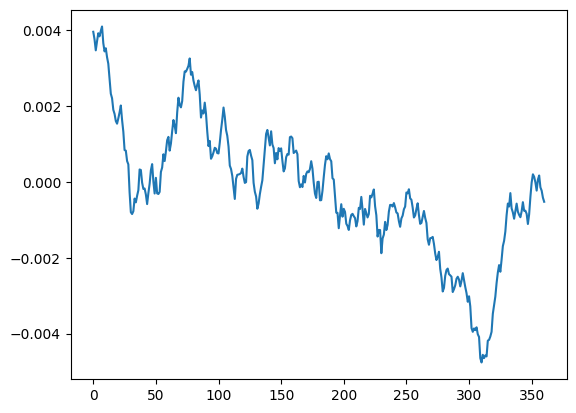

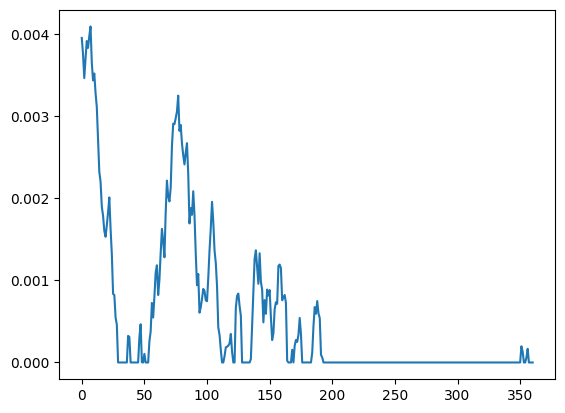

[0.00256636 0.00300079 0.00343831 0.00387189 0.00431845 0.00476009
 0.00520117 0.00565293 0.00610687 0.00656203 0.00702075 0.00748641
 0.00795176 0.00842496 0.00888371 0.00934813 0.00984426 0.0103249
 0.0108019  0.01127666 0.01175137 0.01221747 0.01272383 0.01323247
 0.01373032 0.0137427  0.01373946 0.01374587 0.01376028 0.01380183
 0.01381233 0.01381441 0.01378753 0.01379677 0.01379967 0.01378698
 0.01378475 0.01375095 0.01376478 0.01377307 0.01377346 0.01377634
 0.01379142 0.01379936 0.01376717 0.01376761 0.01376427 0.01376249
 0.01378873 0.01377833 0.01377049 0.01378569 0.01379547 0.01376986
 0.01375929 0.01374124 0.01375568 0.0137396  0.0137326  0.01372856
 0.01372761 0.01373794 0.01372688 0.01370209 0.01369671 0.01370871
 0.01371032 0.01367542 0.01367854 0.0136835  0.01369056 0.01367997
 0.01365263 0.01365547 0.0136431  0.01363438 0.01363294 0.01363757
 0.01363302 0.01364617 0.01365665 0.01365845 0.01367935 0.01366307
 0.01366409 0.01369568 0.01368991 0.01369027 0.01367573 0.01368

In [64]:
np.random.seed(1729)

print("Prices without Antithetic")
fa, sa = price_bond(10000)
print_stats(fa, sa)

Prices with Antithetic


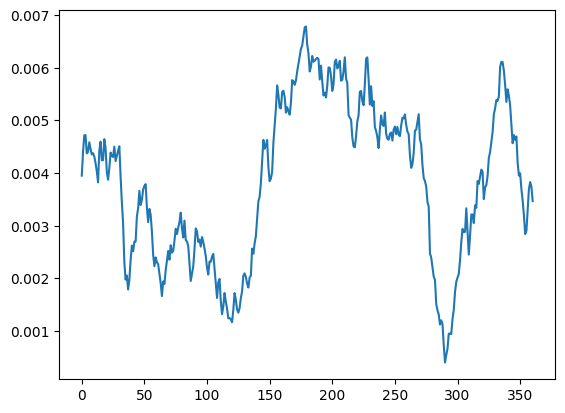

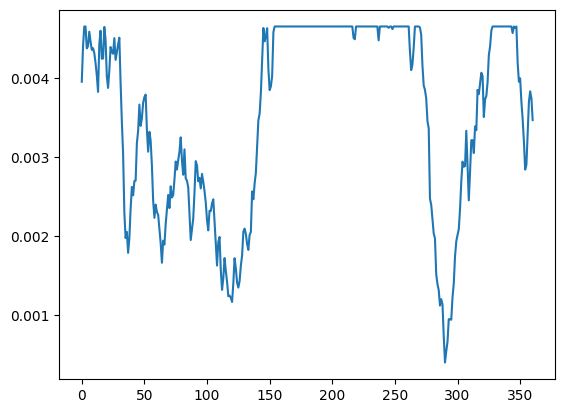

[0.00256636 0.00299267 0.00342303 0.00386414 0.00430957 0.00475504
 0.00519264 0.00564216 0.00608728 0.00654052 0.00700234 0.00746477
 0.00792441 0.00838207 0.00881765 0.00928474 0.00976909 0.01023095
 0.01069719 0.011185   0.01166941 0.01213801 0.01261857 0.01310488
 0.01361036 0.01358746 0.0135848  0.01358892 0.01358984 0.01357556
 0.01358287 0.01360584 0.01363356 0.0136508  0.01368835 0.01370242
 0.01370215 0.01369987 0.01366945 0.01366124 0.01365818 0.01366943
 0.01364927 0.01364396 0.01361994 0.01362249 0.01362307 0.01363674
 0.01361568 0.01361776 0.0135911  0.01361667 0.01364121 0.01363041
 0.01361601 0.01363521 0.01365015 0.01367839 0.01366987 0.01367342
 0.01367879 0.01368037 0.01368819 0.013701   0.01369615 0.01369237
 0.01368938 0.01367096 0.01366264 0.01365612 0.0136723  0.01366165
 0.01366401 0.01366182 0.01365002 0.01364926 0.01364216 0.01364845
 0.01362707 0.01363653 0.01365647 0.01364431 0.01364182 0.01365846
 0.01366672 0.01366102 0.01367593 0.01368358 0.01368122 0.0136

In [65]:
print("Prices with Antithetic")
fa, sa = price_bond(10000, anti = True)
print_stats(fa,sa)

# **Q2 b)**

In [66]:
def find_OAS(n = 1, anti = False):
    '''
    Calculate OAS for both bonds
    '''
    ost_init = 94_894_021

    rt, at     = simulate_rt_at(n, anti = anti)
    ten_yr_rt  = ten_year_rate(rt)
    Zs         = calc_Zs(at)
    prepay_ts  = prepayment_ts(ten_yr_rt)
    Ms, Is, Ps = pool_cf(prepay_ts)
    facf, sacf = bond_cfs(Ms, Ps, at)

    def find_fa_OAS(fa_oas):
        '''
        Calculate residual given a specific OAS for the floater
        '''
        Zs = calc_Zs(at + fa_oas)
        pv = np.sum((facf * Zs), axis = 1).mean()
        return ost_init - pv

    def find_sa_OAS(sa_oas):
        '''
        Calculate residual given a specific OAS for the inverse floater
        '''
        Zs = calc_Zs(at + sa_oas)
        pv = np.sum((sacf * Zs), axis = 1).mean()
        return ost_init - pv

    # fsolve to get the value of OAS to get par
    fa_oas     = fsolve(find_fa_OAS, 0)
    sa_oas     = fsolve(find_sa_OAS, 0)
    return fa_oas[0], sa_oas[0]

In [70]:
oas_without = find_OAS(10_000)
print("OAS for FA without antithetic: ", oas_without[0])
print("OAS for SA without antithetic: ", oas_without[1])

OAS for FA without antithetic:  0.008959489584289321
OAS for SA without antithetic:  -0.2334334761222456


In [71]:
oas_anti = find_OAS(10_000, anti = True)
print("OAS for FA with antithetic: ", oas_anti[0])
print("OAS for SA with antithetic: ", oas_anti[1])

OAS for FA with antithetic:  0.009048932591643846
OAS for SA with antithetic:  -0.2326958355487954
